In [1]:
using Distributions, DistributionsAD, Plots, StatsPlots, LinearAlgebra, KernelFunctions, BlockDiagonals, MLDatasets, Zygote, LinearAlgebra

In [2]:
import Base.+, Base.-, Base.*
using Flux


struct Gaussian
    μ
    Σ
end
Flux.@functor Gaussian


+(x::Gaussian, y::Gaussian) = Gaussian(x.μ .+ y.μ, x.Σ .+ y.Σ)
+(x::Gaussian, y::Vector) = Gaussian(x.μ .+ y, x.Σ)
+(x::Vector, y::Gaussian) = Gaussian(x .+ y.μ, y.Σ)

-(x::Gaussian, y::Gaussian) = Gaussian(x.μ .- y.μ, x.Σ .+ y.Σ)
-(x::Gaussian, y::Vector) = Gaussian(x.μ .- y, x.Σ)
-(x::Vector, y::Gaussian) = Gaussian(x .- y.μ, y.Σ)

*(x::Matrix, y::Gaussian) = Gaussian(x*y.μ, (x)*y.Σ*transpose(x))
        
*(x::Gaussian, y::Real) = Gaussian(y.*x.μ, y^2 .*x.Σ)
*(x::Real, y::Gaussian) = Gaussian(x.*y.μ, x^2 .*y.Σ)

Gaussian(m::Gaussian, S) = Gaussian(m.μ, S.+m.Σ)
Distributions.MvNormal(m::Gaussian) = Distributions.MvNormal(m.μ, Matrix(Hermitian(m.Σ.+Diagonal(ones(length(m.μ)).*1e-6))))

In [3]:
mutable struct SEKernel <: KernelFunctions.Kernel
     
    se_variance
    se_lengthscale

end

Flux.@functor SEKernel


SEKernel() = SEKernel(zeros(1,1), zeros(1,1))


function KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix)

    diffed = sum((Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
    
    return exp(m.se_variance[1,1]) .* exp.(- 0.5 *exp(m.se_lengthscale[1,1]) .* diffed)

end

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)


function crossderivativekernel(m::SEKernel,x::Matrix,y::Matrix,i=1)

    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]
    kern = kernelmatrix(m,x,y)
    
    result =  exp(m.se_lengthscale[1,1]) .* diffed .* kern
    
    return result
    
end


crossderivativekernel(m::SEKernel,x::Matrix) = crossderivativekernel(m,x,x)
crossderivativekernel(m::SEKernel,x::Matrix,i::Int) = crossderivativekernel(m,x,x,i)


function doaug(k,n,m)
    
    result = zeros(k,k,n,m,k*n,k*m)
    
    for i in 1:k
        for j in 1:k
            for s in 1:n
                for t in 1:m
                    result[i,j,s,t,((i-1)*n+s),((j-1)*m+t)] = 1.
                end
            end
        end
    end
    
    return result
end
Zygote.@nograd doaug


function derivativekernel(m::SEKernel, x::Matrix, y::Matrix,i=1)
    
    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]

    kern = kernelmatrix(m,x,y)
    
    result =  (exp(m.se_lengthscale[1,1]) .- exp(m.se_lengthscale[1,1]).^2 .* diffed.^2) .* kern
        
    return result
end


derivativekernel(m::SEKernel,x::Matrix) = derivativekernel(m,x,x)
derivativekernel(m::SEKernel,x::Matrix,i::Int) = derivativekernel(m,x,x,i)

derivativekernel (generic function with 4 methods)

In [4]:
struct SVGPG
     
    L
    a
    I
    
    kern
    s
    
end
Flux.@functor SVGPG



SVGPG(X, kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), X[:,1:nind], kern, zeros(1,1))

SVGPG(kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), rand(ndims,nind).*6 .-3, kern, zeros(1,1))


function (m::SVGPG)(x)
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = kernelmatrix(m.kern,m.I,x)
    Knn = kernelmatrix(m.kern,x)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end



struct ∂SVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


∂(m::SVGPG) = ∂SVGPG(m)

function (mm::∂SVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = derivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end





struct CrossSVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


cross(m::SVGPG) = CrossSVGPG(m)

function (mm::CrossSVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = crossderivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end


In [5]:


function get_kldiv(m::SVGPG)
    
    return get_inducing_kldiv(m)
    
end

function get_kldiv(m::SVGPG, x,xmin,xmax,nn)
    
    return get_inducing_kldiv(m)
    
end

function get_inducing_kldiv(m::SVGPG)

    _,mm = size(m.I)
    
    mv = m.a
    Sv = m.L*transpose(m.L)
    
    mp = zeros(1,mm)
    Sp = kernelmatrix(m.kern,m.I)
    
    
    return sum(kldiv(mv,Sv,mp,Sp))

end





function llnormal(x,m,s)
       
    return -0.5 * log(2 * 3.14 * s) - 1/(2*s)*(x-m)^2
    
end

    
function logdetcholesky(X)
    
    m,n = size(X)
    
    return 2 * sum(log.(diag(cholesky(Symmetric(X.+Diagonal(ones(n).*1e-5))).L)))
    
end


function kldiv(m1,S1,m2,S2)
    
    
    _,N = size(m1)
        
    mdiff = m2.-m1
    
    S2L = cholesky(S2.+Diagonal(ones(N).*1e-5))
    S2LL = S2L.L
    S2LU = S2L.U
    
    
    return 0.5*(logdetcholesky(S2)-logdetcholesky(S1) - N + tr(S2LU\(S2LL\S1)) + (mdiff*(S2LU\(S2LL\transpose(mdiff))))[1])

end


function dosample(X,n_sample)
        
    _,N = size(X)
    return randn(n_sample,N)
        
end
Zygote.@nograd dosample

function sample(m::SVGPG, X,n_sample = 10)
    
    model = m(X)
    
    m = Flux.unsqueeze(model.μ,1)
    S = model.Σ
        
    return (dosample(X,n_sample).+m).*Flux.unsqueeze(sqrt.(diag(S)),1)
    
end

sample (generic function with 2 methods)

In [6]:
mutable struct ClassifierSVGPG
    
    SVGPG
    
end
Flux.@functor ClassifierSVGPG




    

applyn(f,X,n_sample) = Flux.unsqueeze(sample(f,X,n_sample),1)

function sample(m::ClassifierSVGPG, X,n_sample = 10)
    
    samples = sample(m.SVGPG,X,n_sample)
    
    return σ.(samples)
    
end



function sample_elbo(m::ClassifierSVGPG,X,y,N,n_sample=10)
    
    sigmoid_samples = sample(m, X,n_sample)
    yaug = y
    
    avg_ll = mean(mean(-log.(sigmoid_samples).*yaug .- log.(1 .- sigmoid_samples).*(1 .- yaug),dims=1))
    kldiv = sum(get_inducing_kldiv(m.SVGPG))
    

    
    return avg_ll + kldiv
    
end

sample_elbo (generic function with 2 methods)

In [7]:
xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
xtest, ytest = MLDatasets.MNIST.testdata(Float32)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [8]:
idx = map(x->x in [0,1], ytrain)

xtrainS = xtrain[:,:,idx]
xtrainS = reshape(xtrainS, (28*28,size(xtrainS,3)))

ytrainS = Flux.onehotbatch(ytrain[idx],[1,0])[1:1,:]

1×12665 Matrix{Bool}:
 0  1  1  1  1  0  1  1  0  0  1  0  0  …  0  0  0  0  1  1  1  0  1  1  0  1

In [47]:
using Random
Random.seed!(123)

test2 = ClassifierSVGPG(SVGPG(xtrainS, SEKernel(), 784, 10))

params = Flux.params(test2)
opt = ADAM(0.01)

for i in 1:2500
    
    _,N = size(xtrainS)
    samp = rand(1:N,50)
    
    grads = Zygote.gradient(()->sample_elbo(test2, xtrainS[:,samp], ytrainS[:,samp],20,N),params)
    
    for p in params
        if !isnothing(grads[p])
            grads[p] = Float64.(grads[p])
        end
    end
    
    
    Flux.Optimise.update!(opt,params,grads)
    
    if i%250 == 0
        println(sample_elbo(test2, xtrainS[:,samp], ytrainS[:,samp],20, N))
    end
end

0.9934970200344698
0.9083459519478906
0.8966075082546071
0.8843539533811551
0.8681466875035906
0.8544955997680359
0.8376749699327966
0.7316655135252065
0.7035475241539442
0.6977816921178156


In [48]:
#∂(test)(xtrainS[:,1:1])

In [49]:
test2.SVGPG

SVGPG([-0.06191077655026556 -0.10900773942855646 … -0.028014278486915338 0.3993444543054457; -0.24868734421964658 -0.4577357843345132 … 0.1414754025716809 0.485073594491498; … ; 0.0166155027489253 -0.31669788601695914 … 0.005734755466621886 0.2980374846069836; 0.1063271802393881 -0.3863710647476523 … 0.6316443416620474 0.5617178804718816], [-0.02632073596422556 -0.02037825621232952 … -0.01885850686991185 -0.003657746722326801], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SEKernel([0.1931284431465941;;], [-6.576689138027111;;]), [-8.992987176087974;;])

In [50]:
∂test2 = ∂(test2.SVGPG)
crosstest2 = cross(test2.SVGPG)

CrossSVGPG(SVGPG([-0.06191077655026556 -0.10900773942855646 … -0.028014278486915338 0.3993444543054457; -0.24868734421964658 -0.4577357843345132 … 0.1414754025716809 0.485073594491498; … ; 0.0166155027489253 -0.31669788601695914 … 0.005734755466621886 0.2980374846069836; 0.1063271802393881 -0.3863710647476523 … 0.6316443416620474 0.5617178804718816], [-0.02632073596422556 -0.02037825621232952 … -0.01885850686991185 -0.003657746722326801], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SEKernel([0.1931284431465941;;], [-6.576689138027111;;]), [-8.992987176087974;;]))

In [51]:
using BigCombinatorics

ds(k,n,x) = (-1)^(k+1)*factorial(k-1)*Stirling2(n+1,k)*σ(x)^k
snk(n,x) = sum([ds(k,n,x) for k in 1:n+1])


function taylorApproximation(m,Σ)
    
    μX = m[1]
    μY = m[2]
    σXY = Σ[1,2]
    σXX = Σ[1,1]
    σYY = Σ[2,2]
    
    return snk(1,μX)*μY+σXX/2*(snk(3,μX)*μY+2*(σXY/σXX)*snk(2,μX))

end


taylorApproximation (generic function with 1 method)

In [52]:
function dograd(x, i)
    
    f = test2.SVGPG(x)
    fp = ∂test2(x,i)
    fpc = crosstest2(x,i)
    
    mf = f.μ[1]
    mfp = fp.μ[1]
    
    vf = f.Σ[1]
    vfp = fp.Σ[1]
    vfpc = fpc.Σ[1]
    
    
    m = [mf,mfp]
    S = [vf vfpc; vfpc vfp]
    
    
    
    return taylorApproximation(m,S)
    
    
end

dograd (generic function with 1 method)

In [53]:
map(x->dograd(xtrainS[:,1:1],x),collect(1:28*28))

784-element Vector{BigFloat}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

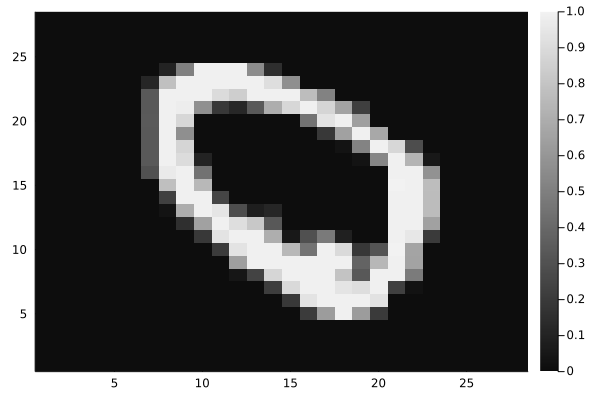

In [140]:
r = 1
heatmap(transpose(reshape(xtrainS[:,r],(28,28))),c=:grays,fmt=:png)

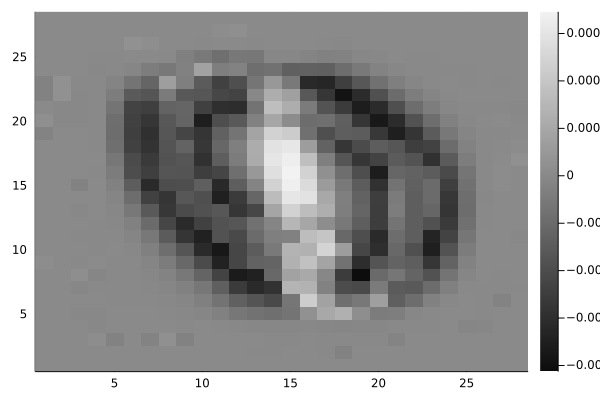

In [141]:

out = Float64.(map(x->dograd(xtrainS[:,r:r],x),collect(1:28*28)))

heatmap(transpose(reshape(out,(28,28))),c=:grays,fmt=:png)

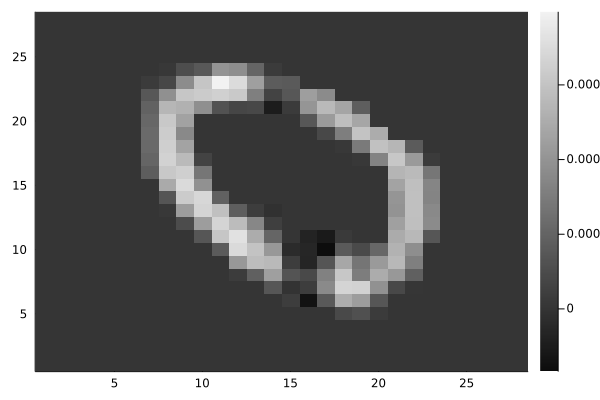

In [142]:
out = zeros(28*28)

for k in collect(0.1:0.1:1)
    out .+= Float64.(map(x->dograd(k.*xtrainS[:,r:r],x),collect(1:28*28)))./length(collect(0.1:0.1:1))
end
heatmap(transpose(reshape(-out.*xtrainS[:,r],(28,28))), c=:grays,fmt=:png)

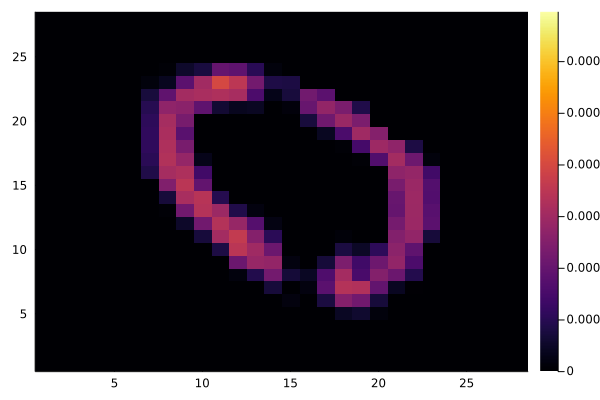

In [143]:
expl = -out.*xtrainS[:,r]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png,clim=(0,maximum(expl).*1.75))

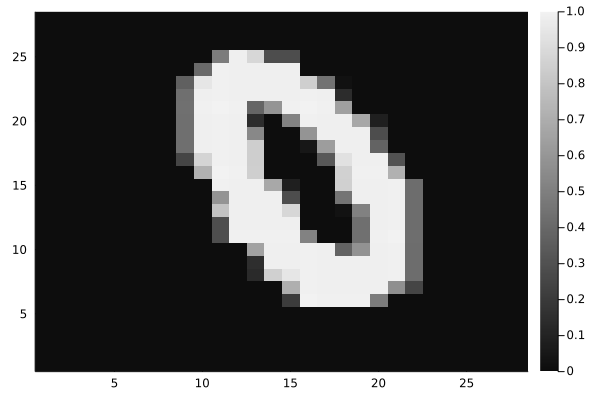

In [144]:
r = 9
heatmap(transpose(reshape(xtrainS[:,r],(28,28))),c=:grays,fmt=:png)

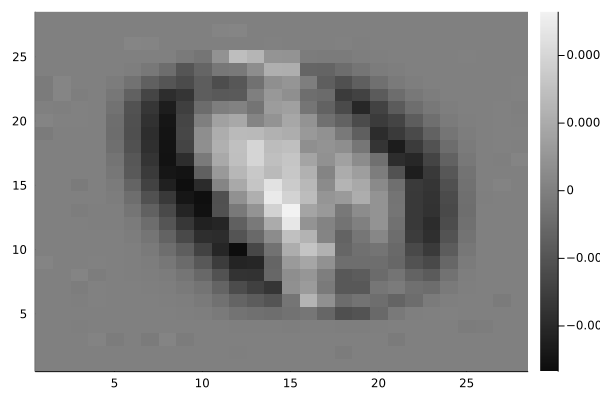

In [145]:

out = Float64.(map(x->dograd(xtrainS[:,r:r],x),collect(1:28*28)))

heatmap(transpose(reshape(out,(28,28))),c=:grays,fmt=:png)

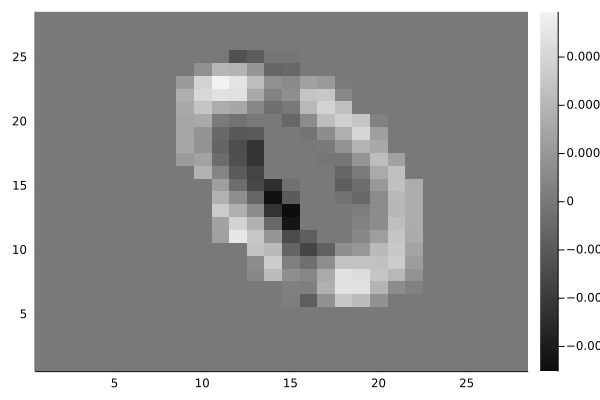

In [146]:
out = zeros(28*28)

for k in collect(0.1:0.1:1)
    out .+= Float64.(map(x->dograd(k.*xtrainS[:,r:r],x),collect(1:28*28)))./length(collect(0.1:0.1:1))
end
heatmap(transpose(reshape(-out.*xtrainS[:,r],(28,28))), c=:grays,fmt=:png)

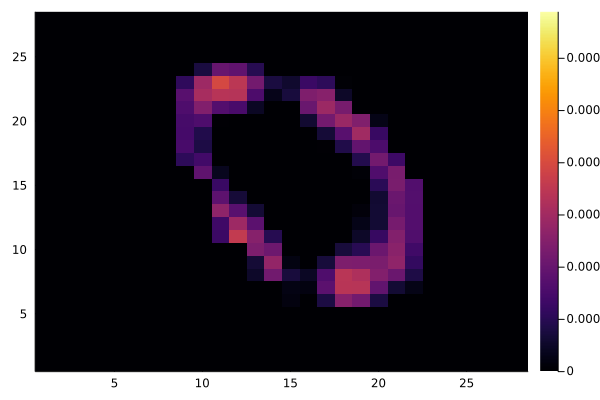

In [147]:
expl = -out.*xtrainS[:,r]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png,clim=(0,maximum(expl).*1.75))

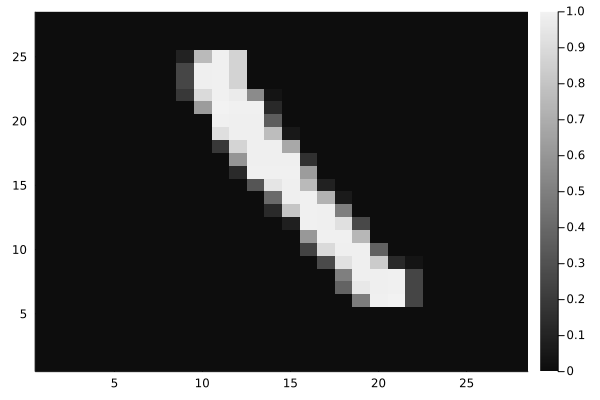

In [148]:
r = 2
heatmap(transpose(reshape(xtrainS[:,r],(28,28))),c=:grays,fmt=:png)

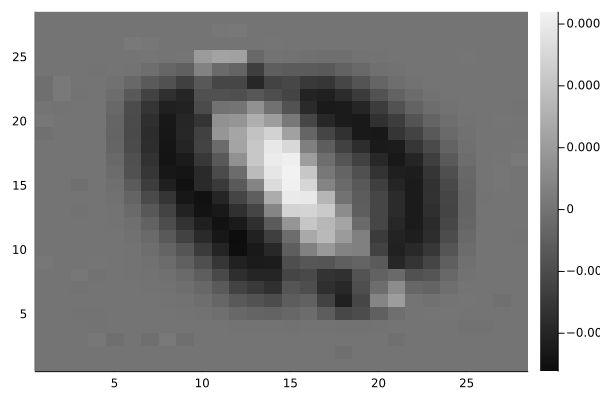

In [149]:

out = Float64.(map(x->dograd(xtrainS[:,r:r],x),collect(1:28*28)))

heatmap(transpose(reshape(out,(28,28))),c=:grays,fmt=:png)

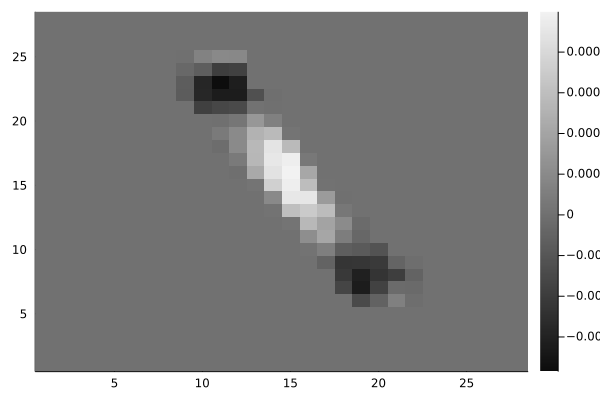

In [150]:
out = zeros(28*28)

for k in collect(0.1:0.1:1)
    out .+= Float64.(map(x->dograd(k.*xtrainS[:,r:r],x),collect(1:28*28)))./length(collect(0.1:0.1:1))
end
heatmap(transpose(reshape(out.*xtrainS[:,r],(28,28))), c=:grays,fmt=:png)

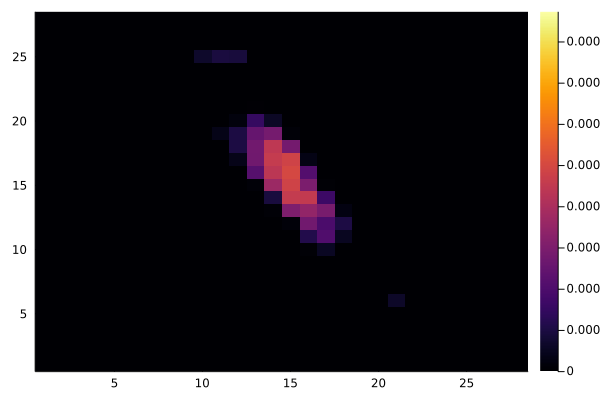

In [151]:
expl = out.*xtrainS[:,r]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png,clim=(0,maximum(expl).*1.75))

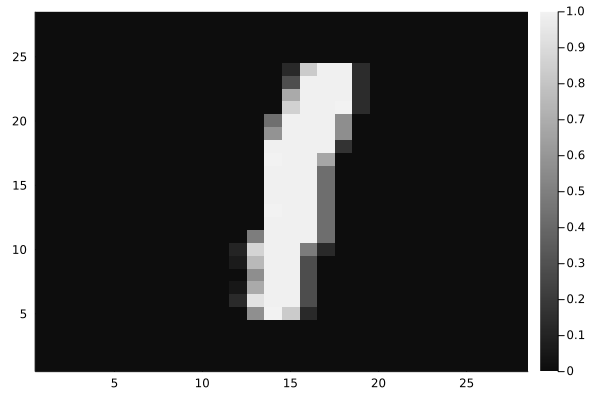

In [152]:
r = 3
heatmap(transpose(reshape(xtrainS[:,r],(28,28))),c=:grays,fmt=:png)

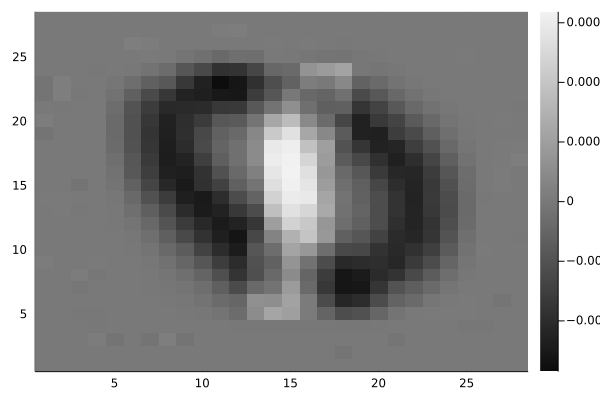

In [153]:

out = Float64.(map(x->dograd(xtrainS[:,r:r],x),collect(1:28*28)))

heatmap(transpose(reshape(out,(28,28))),c=:grays,fmt=:png)

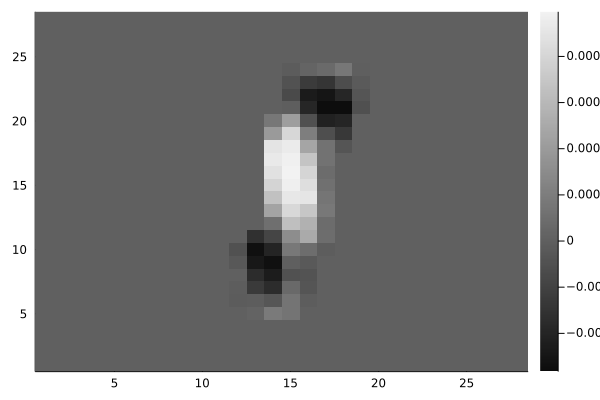

In [154]:
out = zeros(28*28)

for k in collect(0.1:0.1:1)
    out .+= Float64.(map(x->dograd(k.*xtrainS[:,r:r],x),collect(1:28*28)))./length(collect(0.1:0.1:1))
end
heatmap(transpose(reshape(out.*xtrainS[:,r],(28,28))), c=:grays,fmt=:png)

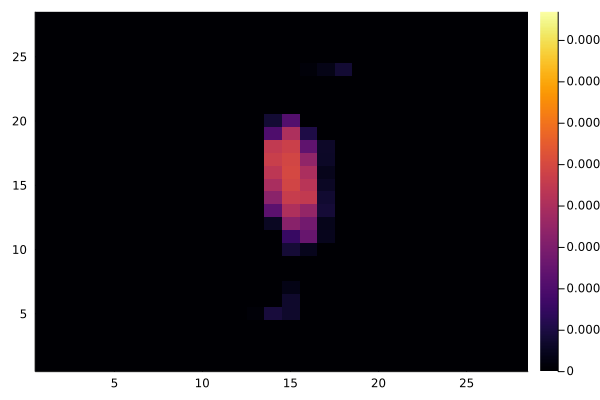

In [155]:
expl = out.*xtrainS[:,r]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png,clim=(0,maximum(expl).*1.75))